## Incorporating Attention-Based GNNs and Graph Transformers with GNNExplainer for Graph Classification in Soccer Counterattack Analysis


### 1. Installing the required Python libraries:

In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [6]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
import requests
from os.path import isfile
import logging
import progressbar
import sys
from ipywidgets import Checkbox, Dropdown, Accordion, VBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import copy
import pickle
import pandas as pd
import random
import time
# Setting up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)

/Users/qflovesy/miniconda3/envs/graphml/lib/python3.8/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: dlopen(/Users/qflovesy/miniconda3/envs/graphml/lib/python3.8/site-packages/torch_spline_conv/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <76699A48-9FE7-3F75-BFDE-78CC0DF1CC3F> /Users/qflovesy/miniconda3/envs/graphml/lib/python3.8/site-packages/torch_spline_conv/_version_cpu.so
  Expected in:     <43579C8C-56B2-3710-B56D-0EEA447F6527> /Users/qflovesy/miniconda3/envs/graphml/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(


### 2. Data Processing

- `get_data()` fetches the specified file (Women, Men, Combined) from a public s3 bucket. The data is stored locally in {women, men, combined}.pkl. It is automatically loaded after downloading.
- Alternatively, the data can be downloaded into propoer directory and loaded from there.

In [59]:
def get_data(file_name):
    '''
    Fetches the file from the location, loads it into memory and returns the data.
    '''
    if not isfile(file_name):
        url = f"https://ussf-ssac-23-soccer-gnn.s3.us-east-2.amazonaws.com/public/counterattack/{file_name}"

        logger.info(f"Downloading data from {url}...")

        r = requests.get(url, stream=True)
        # Fancy code to print progress bar
        block_size = 1024
        n_chunk = 1000
        file_size = int(r.headers.get('Content-Length', None))
        num_bars = np.ceil(file_size / (n_chunk * block_size))
        bar =  progressbar.ProgressBar(maxval=num_bars).start()
        with open(file_name, 'wb') as f:
            for i, chunk in enumerate(r.iter_content(chunk_size=n_chunk * block_size)):
                f.write(chunk)
                bar.update(i+1)
                # Add a little sleep so you can see the bar progress
                time.sleep(0.05)

        logger.info("File downloaded successfully!")

    logger.info(f"Opening {file_name}...")
    with open(file_name, 'rb') as handle:
        data = pickle.load(handle)
    return data

### 2.1 Choose Dataset Type

Choose the type of file for training the GNN. Options available are women's data (which include women's data from the 2022 NWSL and International women's soccer between 2020 and 2022), men's data (data from the 2022 MLS) and a combined data file (includes both women's and men's data).

In [60]:
print("Choose File for training:")
file_widget = Dropdown(
    options=['Women', 'Men', 'Combined'],
    value='Women',
    disabled=False,
)
display(file_widget)

Choose File for training:


Dropdown(options=('Women', 'Men', 'Combined'), value='Women')

### 2.2 (Down)load Data
Using the file selection widget we load the appropriate file from s3.

In [61]:
file_name = file_widget.value.lower() + '.pkl'
# Obtain the data
og_data = get_data(file_name)

Opening women.pkl...
Opening women.pkl...
Opening women.pkl...


Using the file selection widget we load the appropriate file locally.

In [62]:
file_name = file_widget.value.lower() + '.pkl'
logger.info(f"Opening {file_name}...")
with open(file_name, 'rb') as handle:
    og_data = pickle.load(handle)

Opening women.pkl...
Opening women.pkl...
Opening women.pkl...


In [2]:
"""

file_name = './SSAC23 Data/women_imbalanced.pkl'
logger.info(f"Opening {file_name}...")
with open(file_name, 'rb') as handle:
    og_data = pickle.load(handle)
"""

Opening ./SSAC23 Data/women_imbalanced.pkl...


### 2.3 Update dataset with selected features
The loaded dataset is updated to include only the selected node features and edge features

In [63]:
# Define checkboxes for edge features
player_dist = widgets.Checkbox(value=True, description='Player Distance', disabled=False)
speed_diff_matrix = widgets.Checkbox(value=True, description='Speed Difference', disabled=False)
pos_sin_angle = widgets.Checkbox(value=True, description='Positional Sine angle', disabled=False)
pos_cos_angle = widgets.Checkbox(value=True, description='Positional Cosine angle', disabled=False)
vel_sin_angle = widgets.Checkbox(value=True, description='Velocity Sine angle', disabled=False)
vel_cos_angle = widgets.Checkbox(value=True, description='Velocity Cosine angle', disabled=False)

# Define checkboxes for node features
x_coord = widgets.Checkbox(value=True, description='x coordinate', disabled=False)
y_coord = widgets.Checkbox(value=True, description='y coordinate', disabled=False)
vx = widgets.Checkbox(value=True, description='vX', disabled=False)
vy = widgets.Checkbox(value=True, description='vY', disabled=False)
v = widgets.Checkbox(value=True, description='Velocity', disabled=False)
velocity_angle = widgets.Checkbox(value=True, description='Velocity Angle', disabled=False)
dist_goal = widgets.Checkbox(value=True, description='Distance to Goal', disabled=False)
goal_angle = widgets.Checkbox(value=True, description='Angle with Goal', disabled=False)
dist_ball = widgets.Checkbox(value=True, description='Distance to Ball', disabled=False)
ball_angle = widgets.Checkbox(value=True, description='Angle with Ball', disabled=False)
is_attacking = widgets.Checkbox(value=True, description='Attacking Team Flag', disabled=False)
potential_receiver = widgets.Checkbox(value=True, description='Potential Receiver', disabled=False)

# Group edge and node features into VBox widgets
edge_f_box = widgets.VBox([player_dist, speed_diff_matrix, pos_sin_angle, pos_cos_angle, vel_sin_angle, vel_cos_angle])
node_f_box = widgets.VBox([x_coord, y_coord, vx, vy, v, velocity_angle, dist_goal, goal_angle, dist_ball, ball_angle, is_attacking, potential_receiver])

# Create an accordion to toggle between edge and node features
accordion = widgets.Accordion(children=[edge_f_box, node_f_box])
accordion.set_title(0, 'Edge Features')
accordion.set_title(1, 'Node Features')

# Display the accordion
display(accordion)

Accordion(children=(VBox(children=(Checkbox(value=True, description='Player Distance'), Checkbox(value=True, d…

In [65]:
def filter_features(data, adj_matrix='normal'):
    """
    Filter the node and edge features based on user selections.
    """
    # Extract user selections for edge features
    edge_feature_idxs = [idx for idx, cb in enumerate(edge_f_box.children) if cb.value]
    node_feature_idxs = [idx for idx, cb in enumerate(node_f_box.children) if cb.value]

    # Check for valid feature selection
    if not edge_feature_idxs and not node_feature_idxs:
        print("\nCannot have zero edge and zero node features.\n")
        return data

    # Filter node and edge features in the data
    if adj_matrix is not None:
        data[adj_matrix]['e'] = [x[:, edge_feature_idxs] for x in data[adj_matrix]['e']]
        data[adj_matrix]['x'] = [x[:, node_feature_idxs] for x in data[adj_matrix]['x']]
    else:
        data['e'] = [x[:, edge_feature_idxs] for x in data['e']]
        data['x'] = [x[:, node_feature_idxs] for x in data['x']]
        

    return data

# Apply feature filtering
filtered_data = filter_features(og_data.copy(), adj_matrix="delaunay")

In [8]:
# filtered_data

In [70]:
def process_data(data, adj_matrix='normal'):
    """
    Converts the filtered dataset to PyTorch Geometric format.
    """
    if adj_matrix is not None:
        data_mat = data[adj_matrix]
    else:
        data_mat = data
    graph_list = []

    for x, a, e, y in zip(data_mat['x'], data_mat['a'], data_mat['e'], data['binary']):
        # Convert sparse matrix to COO format (edge_index)
        a_coo = a.tocoo()  # Convert sparse matrix to COO format

        # Convert edge indices to numpy array and then to tensor
        edge_index = np.vstack([a_coo.row, a_coo.col])
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Create PyG Data object
        graph_data = Data(
            x=torch.tensor(x, dtype=torch.float),
            edge_index=edge_index,
            edge_attr=torch.tensor(e, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float).view(1, -1)
        )
        graph_list.append(graph_data)

    return graph_list

# Convert to PyG dataset
data_list = process_data(filtered_data, adj_matrix="delaunay")

# Display the number of graphs processed
print(f"Number of graphs processed: {len(data_list)}")

Number of graphs processed: 4348


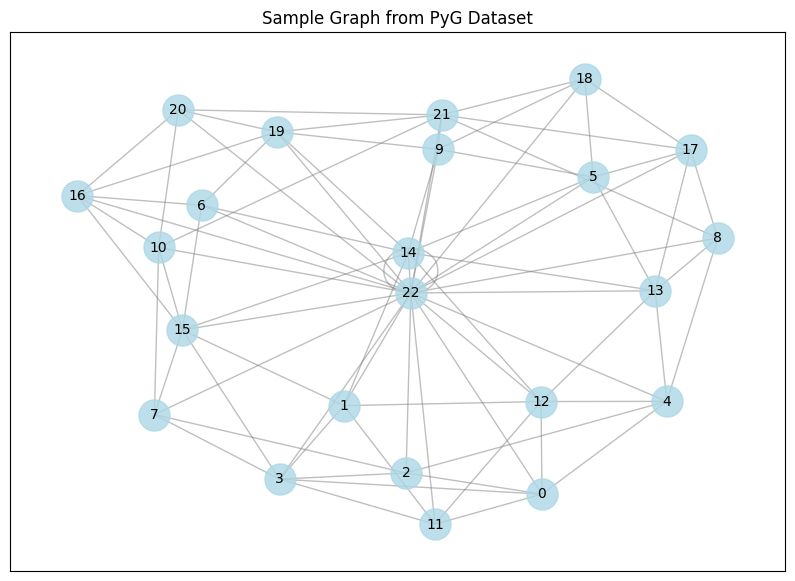

In [71]:
def visualize_graph_simple(data, node_color='lightblue', edge_color='gray'):
    """
    Visualize a single graph from the PyG dataset without showing vectors.
    """
    # Convert PyG data to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Set up node labels as simple indices
    node_labels = {i: i for i in range(data.num_nodes)}

    # Plotting
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)  # Spring layout for better visualization

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    plt.title("Sample Graph from PyG Dataset")
    plt.show()

# Select a sample graph from the preprocessed dataset
sample_graph = data_list[0]

# Visualize the selected sample graph
visualize_graph_simple(sample_graph)


0: 0.0
attflag 0.10000000149011612
1: 0.0
attflag 0.10000000149011612
2: 0.0
attflag 0.10000000149011612
3: 0.0
attflag 0.10000000149011612
4: 0.0
attflag 0.10000000149011612
5: 0.0
attflag 0.10000000149011612
6: 0.0
attflag 0.10000000149011612
7: 0.0
attflag 0.10000000149011612
8: 0.0
attflag 0.10000000149011612
9: 0.0
attflag 0.10000000149011612
10: 0.0
attflag 0.10000000149011612
11: 0.0
attflag 0.10000000149011612
12: 0.0
attflag 0.10000000149011612
13: 0.0
attflag 0.10000000149011612
14: 0.0
attflag 0.10000000149011612
15: 0.0
attflag 0.10000000149011612
16: 0.0
attflag 0.10000000149011612
17: 0.0
attflag 0.10000000149011612
18: 0.0
attflag 0.10000000149011612
19: 0.0
attflag 0.10000000149011612
20: 0.0
attflag 0.10000000149011612
21: 0.0
attflag 0.10000000149011612
22: 0.0
attflag 0.10000000149011612
23: 0.0
attflag 0.10000000149011612
24: 0.0
attflag 0.10000000149011612
25: 0.0
attflag 0.10000000149011612
26: 0.0
attflag 0.10000000149011612
27: 0.0
attflag 0.10000000149011612
28

KeyboardInterrupt: 

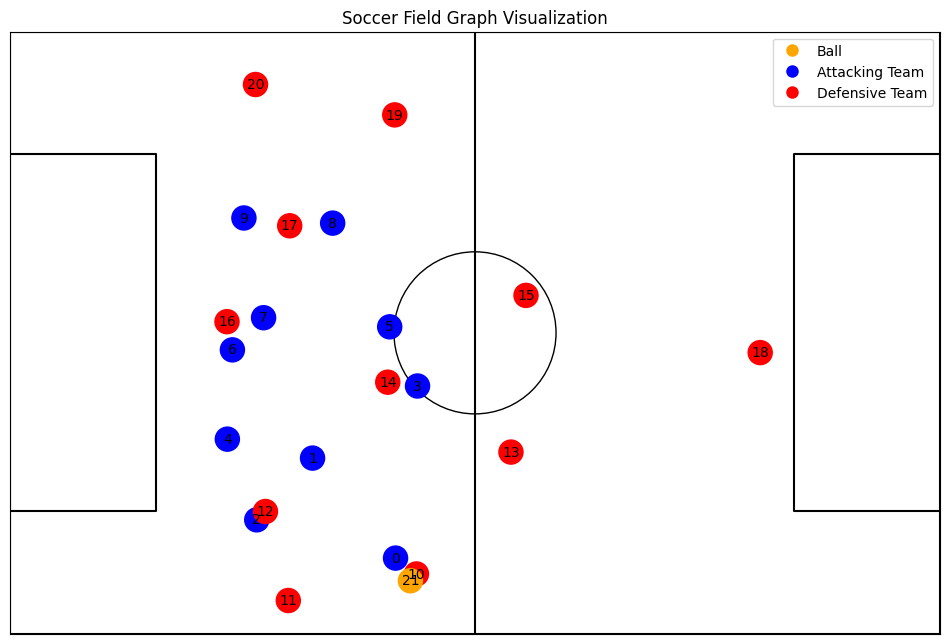

In [49]:
def draw_soccer_field(ax=None):
    """
    Draws a 2D soccer field on a Matplotlib axis.
    """
    if ax is None:
        ax = plt.gca()

    # Soccer field dimensions (in meters)
    field_length = 105
    field_width = 68

    # Outline & center line
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([field_length / 2, field_length / 2], [0, field_width], color="black")

    # Center circle
    center_circle = plt.Circle((field_length / 2, field_width / 2), 9.15, color="black", fill=False)
    ax.add_artist(center_circle)

    # Penalty area (left & right)
    penalty_area_width = 40.3
    penalty_area_length = 16.5
    ax.plot([0, penalty_area_length, penalty_area_length, 0],
            [(field_width - penalty_area_width) / 2, (field_width - penalty_area_width) / 2,
             (field_width + penalty_area_width) / 2, (field_width + penalty_area_width) / 2],
            color="black")
    ax.plot([field_length, field_length - penalty_area_length, field_length - penalty_area_length, field_length],
            [(field_width - penalty_area_width) / 2, (field_width - penalty_area_width) / 2,
             (field_width + penalty_area_width) / 2, (field_width + penalty_area_width) / 2],
            color="black")

    # Set field limits and aspect ratio
    ax.set_xlim(0, field_length)
    ax.set_ylim(0, field_width)
    ax.set_aspect('equal')

def identify_teams_and_ball(data):
    """
    Identifies the ball and teams based on the attacking team flag.
    - Ball: The node with the highest degree.
    - Team 1: Nodes with Attacking Team Flag = 1 (attacking team).
    - Team 2: Nodes with Attacking Team Flag = 0 (defensive team).
    """
    # Convert PyG data to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Find the node with the highest degree (ball node)
    degrees = dict(G.degree())
    ball_node = max(degrees, key=degrees.get)

    # Team 1 and Team 2 based on Attacking Team Flag
    print("attflag " + str(data.x[0][-2].item()))
    team1_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 1]  # Attacking team
    team2_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 0]  # Defensive team

    return G, ball_node, team1_nodes, team2_nodes

def visualize_soccer_graph(data, save_file=""):
    """
    Visualizes the soccer graph on a 2D soccer field with a legend.
    - Identifies the ball and teams based on the attacking team flag.
    """
    # Identify the ball and teams based on the flag
    G, ball_node, team1_nodes, team2_nodes = identify_teams_and_ball(data)

    # Extract node positions from node features and scale to field dimensions
    field_length = 105
    field_width = 68
    node_positions = {i: (data.x[i][0].item() * field_length, data.x[i][1].item() * field_width)
                      for i in range(data.num_nodes)}

    # Define colors for ball, attacking team, and defensive team
    node_colors = []
    for i in range(data.num_nodes):
        if i == ball_node:
            node_colors.append('orange')  # Ball color
        elif i in team1_nodes:
            node_colors.append('blue')  # Attacking team color
        else:
            node_colors.append('red')  # Defensive team color

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Draw the soccer field
    draw_soccer_field(ax)

    # Draw nodes (players/ball)
    nx.draw_networkx_nodes(G, node_positions, node_color=node_colors, node_size=300, ax=ax)

    # # Draw edges within teams and between team members and the ball
    # for u, v in G.edges():
    #     if (u == ball_node or v == ball_node) or (u in team1_nodes and v in team1_nodes) or (u in team2_nodes and v in team2_nodes):
    #         nx.draw_networkx_edges(G, node_positions, edgelist=[(u, v)], edge_color='gray', ax=ax)

    # Add labels for node indices
    nx.draw_networkx_labels(G, node_positions, ax=ax, font_size=10, font_color='black')

    # Add legend
    legend_labels = {'orange': 'Ball', 'blue': 'Attacking Team', 'red': 'Defensive Team'}
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color],
                                 markerfacecolor=color, markersize=10) for color in legend_labels]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.title("Soccer Field Graph Visualization")
    if len(save_file) == 0:
        plt.show()
    else:
        plt.savefig(save_file)
        

# Visualize a sample graph from the dataset on a soccer field
# visualize_soccer_graph(dat/a_list[2])

filenames = []

# Generate frames
for i in range(300):
    if data_list[i].id.item() == 1:
        filename = f"frame_{i}.png"
        print(f"{i}: {data_list[i].y.item()}")
        visualize_soccer_graph(data_list[i], filename)
        filenames.append(filename)
        plt.close()

# Display the frames (optional)
print("Frames generated.")

In [46]:
[idx for idx, cb in enumerate(node_f_box.children) if cb.value]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [45]:
og_data["node_feature_names"]
og_data["x"][0][:,12]

array([0.99868291, 0.61985722, 0.97511477, 0.98374864, 0.92144295,
       0.99912722, 0.99424513, 0.80289991, 0.96798791, 0.98272529,
       0.85355339, 0.930043  , 0.97219635, 0.00922714, 0.15858576,
       0.45553403, 0.99065687, 0.98063494, 0.32475316, 0.85355339,
       0.85700244, 0.56124083])

In [20]:
data = data_list[0]
G = to_networkx(data, to_undirected=True)

# Find the node with the highest degree (ball node)
degrees = dict(G.degree())
ball_node = max(degrees, key=degrees.get)

# Team 1 and Team 2 based on Attacking Team Flag
team1_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 1]  # Attacking team
team2_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 0]  # Defensive team

In [24]:
data.num_nodes

22

In [26]:
import imageio
with imageio.get_writer('animated_sine_wave.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF created: animated_sine_wave.gif")

/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_30505/3198409380.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created: animated_sine_wave.gif


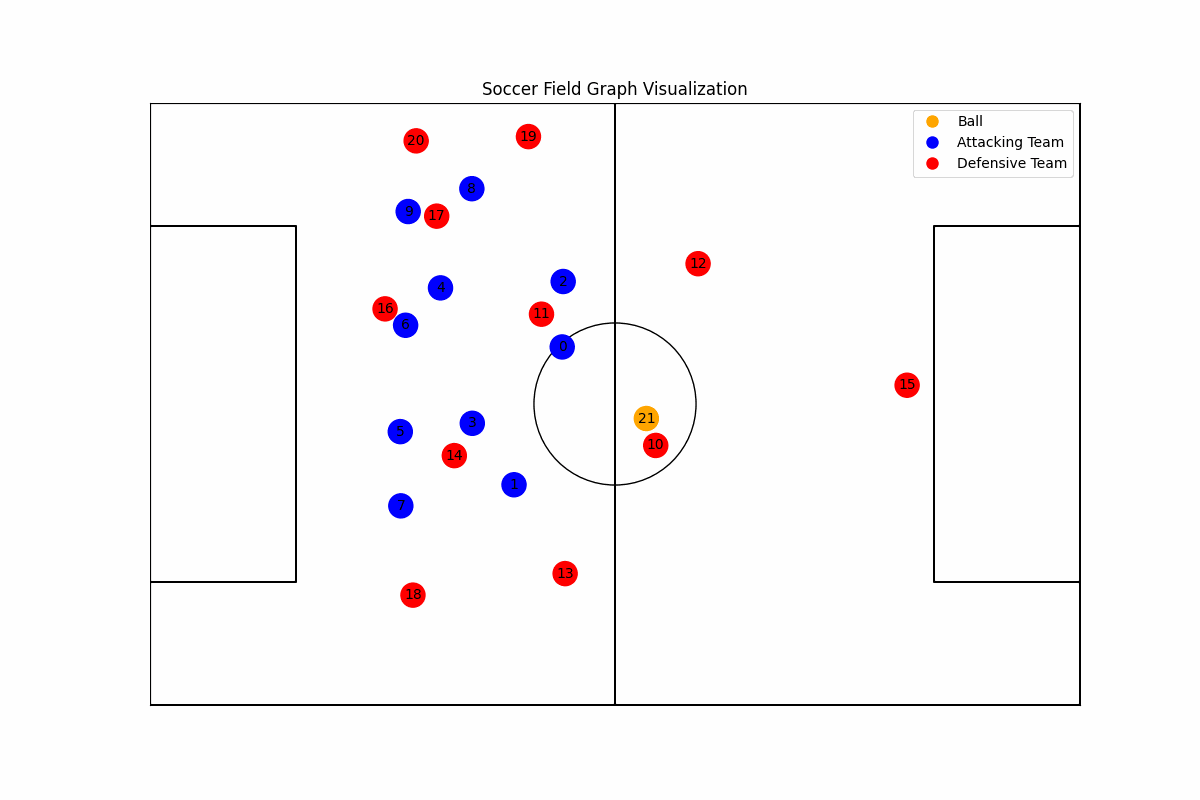

In [28]:
from IPython.display import Image

Image(filename="animated_sine_wave.gif")

In [20]:
import os
for filename in filenames:
    os.remove(filename)

NameError: name 'filenames' is not defined

* Edge Features:
  * Player Distance - Distance between two players connected to each other
  * Speed Difference - Speed difference between two players connected to each other
  * Positional Sine angle - Sine of the angle created between two players in the edge
  * Positional Cosine angle - Cosine of the angle created between two players in the edge
  * Velocity Sine angle - Sine of the angle created between the velocity vectors of two players in the edge
  * Velocity Cosine angle - Coine of the angle created between the velocity vectors of two players in the edge
      
* Node Features:
  * x coordinate - x coordinate on the 2D pitch for the player / ball
  * y coordinate - y coordinate on the 2D pitch for the player / ball
  * vx - Velocity vector's x coordinate
  * vy - Velocity vector's y coordinate
  * Velocity - magnitude of the velocity
  *  Velocity Angle - angle made by the velocity vector
  * Distance to Goal - distance of the player from the goal post
  * Angle with Goal - angle made by the player with the goal
  * Distance to Ball - distance from the ball (always 0 for the ball)
  * Angle with Ball - angle made with the ball (always 0 for the ball)
  * Attacking Team Flag - 1 if the team is attacking, 0 if not and for the ball
  * Potential Receiver - 1 if player is a potential receiver, 0 otherwise

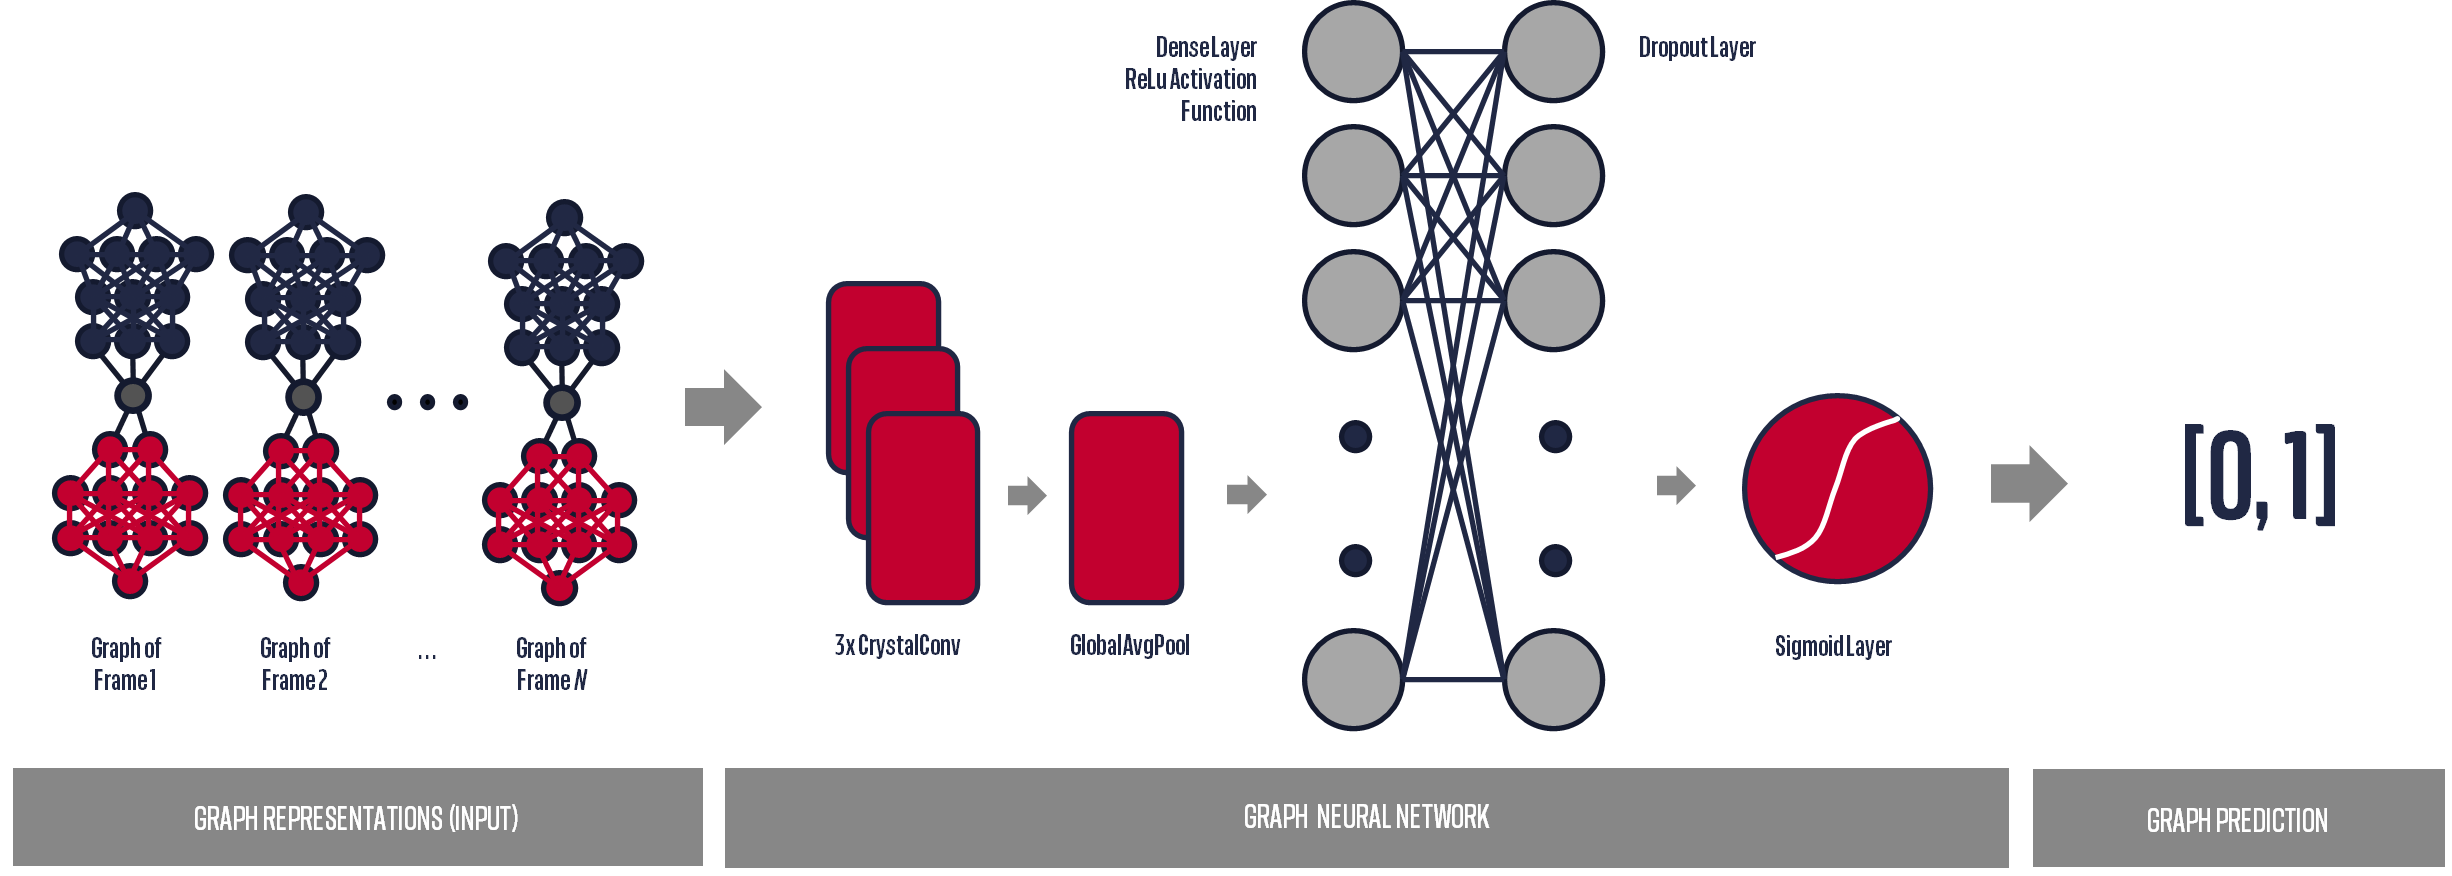

### 3. Training with GCN

Epoch: 010, Train Loss: 0.6285, Val Loss: 0.6309, Val AUC: 0.6801, Val Acc: 0.6272, Val Prec: 0.6903, Val Rec: 0.4343, Val F1: 0.5331
Epoch: 010, Train Loss: 0.6285, Val Loss: 0.6309, Val AUC: 0.6801, Val Acc: 0.6272, Val Prec: 0.6903, Val Rec: 0.4343, Val F1: 0.5331
Epoch: 010, Train Loss: 0.6285, Val Loss: 0.6309, Val AUC: 0.6801, Val Acc: 0.6272, Val Prec: 0.6903, Val Rec: 0.4343, Val F1: 0.5331
Epoch: 020, Train Loss: 0.6106, Val Loss: 0.6277, Val AUC: 0.6869, Val Acc: 0.6444, Val Prec: 0.7010, Val Rec: 0.4789, Val F1: 0.5690
Epoch: 020, Train Loss: 0.6106, Val Loss: 0.6277, Val AUC: 0.6869, Val Acc: 0.6444, Val Prec: 0.7010, Val Rec: 0.4789, Val F1: 0.5690
Epoch: 020, Train Loss: 0.6106, Val Loss: 0.6277, Val AUC: 0.6869, Val Acc: 0.6444, Val Prec: 0.7010, Val Rec: 0.4789, Val F1: 0.5690
Epoch: 030, Train Loss: 0.5973, Val Loss: 0.6229, Val AUC: 0.7063, Val Acc: 0.6352, Val Prec: 0.6501, Val Rec: 0.5540, Val F1: 0.5982
Epoch: 030, Train Loss: 0.5973, Val Loss: 0.6229, Val AUC: 0.7

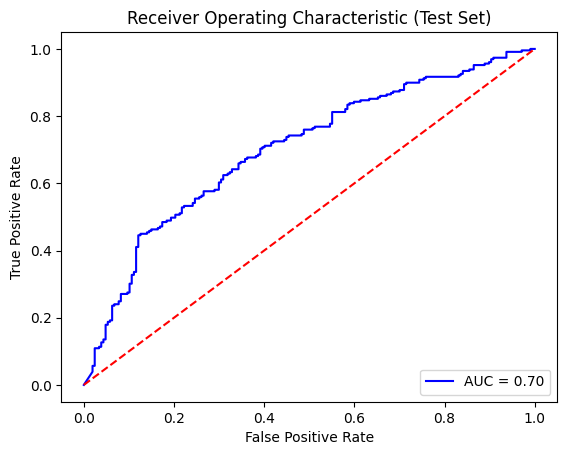

In [121]:
# Hyperparameters
learning_rate = 1e-3  # Learning rate
epochs = 150  # Number of training epochs
batch_size = 16  # Batch size
channels = 128  # Hidden units for the neural network
layers = 3  # Number of GCN layers

# Train/validation/test split
train_size = int(0.7 * len(data_list))
val_size = int(0.2 * len(data_list))
test_size = len(data_list) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(data_list, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=layers):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.dropout = torch.nn.Dropout(0.5)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        if batch is None:
            batch = torch.zeros(x.shape[0], dtype=torch.long)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=data_list[0].num_node_features,
            hidden_channels=channels,
            out_channels=1,
            num_layers=layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)

        # Align target shape with the output
        loss = criterion(out.squeeze(), batch.y.view(-1))

        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(train_loader.dataset)

def compute_metrics(y_true, y_pred, threshold=0.5):
    """
    Compute evaluation metrics based on predictions.
    """
    y_pred_label = (y_pred >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)

    return accuracy, precision, recall, f1

def evaluate(loader, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out.squeeze(), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs

            y_true.append(batch.y.cpu().numpy())
            y_pred.append(out.sigmoid().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    # Compute additional metrics
    accuracy, precision, recall, f1 = compute_metrics(y_true, y_pred, threshold)

    return total_loss / len(loader.dataset), auc_score, accuracy, precision, recall, f1, y_true, y_pred

# Training loop with validation
for epoch in range(1, epochs + 1):
    train_loss = train()

    if epoch % 10 == 0:
        val_loss, val_auc, val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate(val_loader)
        logger.info(
            f"Epoch: {epoch:03d}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Val AUC: {val_auc:.4f}, "
            f"Val Acc: {val_accuracy:.4f}, "
            f"Val Prec: {val_precision:.4f}, "
            f"Val Rec: {val_recall:.4f}, "
            f"Val F1: {val_f1:.4f}"
        )

# Final evaluation on the test set
test_loss, test_auc, test_accuracy, test_precision, test_recall, test_f1, y_true, y_pred = evaluate(test_loader)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Print test results
logger.info(
    f"Test Loss: {test_loss:.4f}, "
    f"Test AUC: {test_auc:.4f}, "
    f"Test Acc: {test_accuracy:.4f}, "
    f"Test Prec: {test_precision:.4f}, "
    f"Test Rec: {test_recall:.4f}, "
    f"Test F1: {test_f1:.4f}"
)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc='lower right')
plt.show()

In [122]:
from torch_geometric.explain import Explainer, GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=150),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type="log_probs",
    ),
)

In [123]:
node_index = 10
explanation = explainer(x=test_data.dataset[0].x, edge_index=test_data.dataset[0].edge_index)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['node_mask', 'edge_mask']


In [124]:
path = './feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

Feature importance plot has been saved to './feature_importance.png'


In [117]:
def apply_sparsity_threshold(explanation, node_threshold=0.5, edge_threshold=0.5):
    # Apply node mask threshold
    node_mask = explanation['node_mask']
    edge_mask = explanation['edge_mask']
    
    # Make sure node_mask and edge_mask are tensors for easy processing
    node_mask_tensor = torch.tensor(node_mask, dtype=torch.float)
    edge_mask_tensor = torch.tensor(edge_mask, dtype=torch.float)
    
    # Apply threshold for nodes
    sparse_node_mask = (node_mask_tensor >= node_threshold).float()
    
    # Apply threshold for edges
    sparse_edge_mask = (edge_mask_tensor >= edge_threshold).float()
    
    # Update the explanation with sparse masks
    explanation['node_mask'] = sparse_node_mask
    explanation['edge_mask'] = sparse_edge_mask
    
    return explanation

In [130]:
new_explanation = apply_sparsity_threshold(explanation.clone(), edge_threshold=0.5)

/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_42023/2887351481.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_mask_tensor = torch.tensor(node_mask, dtype=torch.float)
/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_42023/2887351481.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_mask_tensor = torch.tensor(edge_mask, dtype=torch.float)


In [131]:
path = './subgraph.pdf'
new_explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Subgraph visualization plot has been saved to './subgraph.pdf'


In [133]:
new_explanation.node_mask

tensor([[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
        [0., 1

In [3]:
file_name = './raw_data/women_imbalanced.pkl'
with open(file_name, 'rb') as handle:
    og_data = pickle.load(handle)

In [34]:
df = og_data

In [4]:
len(og_data['id'])

103381

In [55]:
df_list = []
for idx, array in enumerate(og_data['x']):
    # Convert the array to a DataFrame and add an 'ID' column
    df = pd.DataFrame(array, columns=['x', 'y', 'vx', 'vy', 'velocity', 'velocity_angle', 'dist_to_goal', 'angle_goal', 'dist_to_ball', 'angle_ball', 'team_flag', 'potential_receiver', 'sin_ax', 'cos_ay', 'a', 'sin_a', 'cos_a'])
    df['game_id'] = og_data['id'][idx]  # Assign an ID to each row of this array
    df['frame_id'] = idx  # Assign an ID to each row of this array
    df['success'] = og_data['label'][idx][0]
    df_list.append(df)

In [56]:
final_df = pd.concat(df_list, ignore_index=True)

In [57]:
final_df.to_parquet("./soccer_data_full.parquet", index=False)

In [59]:
final_df[final_df["game_id"] == 2]

x         y        vx        vy  velocity  velocity_angle  \
5234  0.333663  0.602059 -0.400924  0.916111     0.083        0.815655   
5235  0.342376  0.743088  0.770300 -0.637682     0.134        0.389947   
5236  0.434455  0.649412  0.426579 -0.904450     0.257        0.320141   
5237  0.232475  0.677206  0.617474  0.786591     0.021        0.644078   
5238  0.416931  0.466471  0.036584 -0.999331     0.260        0.255824   
...        ...       ...       ...       ...       ...             ...   
9875  0.528440  0.722466  0.982217 -0.187747     0.248        0.469941   
9876  0.461101  0.812740  0.823669 -0.567070     0.177        0.404038   
9877  0.461101  0.838904  0.982373 -0.186929     0.147        0.470073   
9878  0.464404  0.377671  0.988999  0.147921     0.282        0.523629   
9879  0.837982  0.808904  0.990248  0.139313     0.161        0.522245   

      dist_to_goal  angle_goal  dist_to_ball  angle_ball  team_flag  \
5234      0.634863    0.983646      0.009881    0.212615        1.0   
5235      0.642268    0.961180      0.069329    0.738678        1.0   
5236      0.544402    0.971984      0.083034    0.532497        1.0   
5237      0.736150    0.975457      0.092108    0.942867        1.0   
5238      0.553013    0.006159      0.108352    0.355674        1.0   
...            ...         ...           ...         ...        ...   
9875      0.468943    0.951294      0.261649    0.029425        0.0   
9876      0.548249    0.941002      0.313148    0.998915        0.0   
9877      0.554485    0.936556      0.313586    0.991523        0.0   
9878      0.513785    0.024158      0.392337    0.104742        0.0   
9879      0.249174    0.855740      0.000000    0.000000        0.0   

      potential_receiver    sin_ax    cos_ay      a     sin_a     cos_a  \
5234                 0.1  0.283784  0.049167  0.422  0.283784  0.049167   
5235                 1.0  0.711119  0.953242  0.476  0.711119  0.953242   
5236                 1.0  0.500000  1.000000  0.370  0.500000  1.000000   
5237                 1.0  0.694650  0.960556  0.541  0.694650  0.960556   
5238                 1.0  0.979395  0.357943  0.597  0.979395  0.357943   
...                  ...       ...       ...    ...       ...       ...   
9875                 0.1  0.082415  0.774995  0.511  0.082415  0.774995   
9876                 0.1  0.000000  0.500000  0.500  0.000000  0.500000   
9877                 0.1  0.003091  0.555513  0.526  0.003091  0.555513   
9878                 0.1  0.684516  0.035292  0.516  0.684516  0.035292   
9879                 0.0  0.987429  0.611412  0.472  0.987429  0.611412   

      game_id  frame_id  success  
5234        2       232        0  
5235        2       232        0  
5236        2       232        0  
5237        2       232        0  
5238        2       232        0  
...       ...       ...      ...  
9875        2       433        1  
9876        2       433        1  
9877        2       433        1  
9878        2       433        1  
9879        2       433        1  

[4646 rows x 20 columns]

In [39]:
a_coo = og_data['a'][0].tocoo()

a1 = np.vstack([a_coo.row, a_coo.col])

a_coo = og_data['a'][10].tocoo()

a2 = np.vstack([a_coo.row, a_coo.col])

In [ ]:
arr = og_data['x'][0]
arr[(arr[:,8] == 0) & (arr[:,9] == 0), 10] = -1


array([[ 0.53371429,  0.47588235, -0.24992889, -0.9682642 ,  0.212     ,
         0.20979638,  0.44385738,  0.00532918,  0.        ,  0.        ,
         0.        ,  0.        ,  0.56124083,  0.00376461,  0.319     ,
         0.56124083,  0.00376461]])

In [34]:
import h5py
def h5_to_dict(h5_obj):
    """
    Recursively convert an h5py File or Group object into a nested dictionary.
    """
    result = {}
    for key, item in h5_obj.items():
        if isinstance(item, h5py.Group):
            result[key] = h5_to_dict(item)  # Recurse into groups
        elif isinstance(item, h5py.Dataset):
            result[key] = item[()]  # Load dataset as NumPy array or scalar
    return result
with h5py.File("processed_data/women_imbalanced_edge_lists.h5", "r") as f:
    edge_lists = h5_to_dict(f)

with h5py.File("processed_data/women_imbalanced_edge_features.h5", "r") as f:
    edge_features = h5_to_dict(f)

with h5py.File("processed_data/women_imbalanced_node_features.h5", "r") as f:
    node_features = h5_to_dict(f)

In [32]:
edge_lists["edge_list_16_1"].shape

(2, 287)

In [33]:
edge_features["edge_features_16_1"].shape

(76, 264, 6)

In [35]:
node_features["node_features_16_1"].shape

(76, 22, 17)

In [59]:
file_name = './raw_data/men.pkl'
with open(file_name, 'rb') as handle:
    og_data = pickle.load(handle)

In [60]:
array = og_data["normal"]["x"][0]

In [62]:
with h5py.File("processed_data/women_node_features.h5", "r") as f:
    node_features = h5_to_dict(f)

In [71]:
edge_lists["edge_list_0"].shape

(2, 287)

In [75]:
for data in ["men", "women"]:
    for at in ["normal", "dense", "delaunay"]:
        pf = f"{data}_{at}"
        with h5py.File(f"processed_data/{pf}_edge_features.h5", "r") as f:
            edge_features = h5_to_dict(f)

        with h5py.File(f"processed_data/{pf}_edge_lists.h5", "r") as f:
            edge_lists = h5_to_dict(f)

        for k in edge_lists.keys():
            num = k.split("_")[-1]
            try:
                assert edge_features[f"edge_features_{num}"].shape[0] == edge_lists[k].shape[1]
            except AssertionError:
                print(f"Error at {k}")


In [ ]:
# game_id_set = set()
# for idx, array in enumerate(og_data['a']):
#     game_id, success = og_data['id'][idx], og_data['label'][idx][0]
#     if (game_id, success) in game_id_set:
#         continue
#     game_id_set.add((game_id, success))
#     try:
#         assert edge_features[f"edge_features_{game_id}_{success}"].shape[1] == edge_lists[f"edge_list_{game_id}_{success}"].shape[1]
#     except AssertionError:
#         print(f"Error at game {game_id} with success {success}")


In [81]:
name = "men_imbalanced"
with h5py.File(f"processed_data/{name}_edge_lists.h5", "r") as f:
    edge_lists = h5_to_dict(f)
with h5py.File(f"processed_data/{name}_edge_features.h5", "r") as f:
    edge_features = h5_to_dict(f)

In [109]:
with h5py.File(f"processed_data/men_imbalanced_edge_features.h5", "r") as f:
    node_features = h5_to_dict(f)

In [2]:
import pandas as pd
df = pd.read_parquet(f"processed_data/men_imbalanced_node_features.parquet")

In [6]:
df.groupby(['game_id', 'success']).ngroup()

0            0
1            0
2            0
3            0
4            0
          ... 
2306412    953
2306413    953
2306414    953
2306415    953
2306416    953
Length: 2306417, dtype: int64

In [18]:
df = pd.read_parquet(f"processed_data/men_imbalanced_node_features.parquet")
df.loc[:, "dist_to_left_boundary"] = df.loc[:, "x"]
df.loc[:, "dist_to_right_boundary"] = 1 - df.loc[:, "x"]
df.loc[:, "att_team"] = df.loc[:, "att_team"].astype(int)
number_of_games = df.loc[:, "game_id"].nunique()

In [19]:
df

x         y        vx        vy      v   angle_v  dist_goal  \
0        0.310182  0.079265  0.913422 -0.407014  0.503  0.433285   0.704344   
1        0.400273  0.038088  0.770371 -0.637596  0.304  0.389965   0.634613   
2        0.322909  0.231176 -0.765800 -0.643079  0.156  0.111172   0.666093   
3        0.516545  0.223529 -0.404175 -0.914682  0.303  0.183779   0.489907   
4        0.174364  0.312353  0.492163 -0.870503  0.104  0.331897   0.796563   
...           ...       ...       ...       ...    ...       ...        ...   
2401673  0.851171  0.563529  0.986400 -0.164364  0.384  0.473721   0.147088   
2401674  0.617117  0.270588  0.979836 -0.199801  0.113  0.467985   0.389977   
2401675  0.464234  0.322206  0.991198 -0.132388  0.171  0.478868   0.522752   
2401676  0.598829  0.759706  0.996247 -0.086552  0.372  0.486208   0.412644   
2401677  0.976937  0.027941  0.904843 -0.425745  0.200  0.430006   0.277386   

         angle_goal  dist_ball  angle_ball  ...    sin_ax    cos_ay      a  \
0          0.057385   0.015574    0.909923  ...  0.082362  0.774916  0.439   
1          0.070723   0.064864    0.467132  ...  0.745898  0.935355  0.292   
2          0.038305   0.088260    0.754184  ...  0.912732  0.782228  0.466   
3          0.054081   0.182922    0.576139  ...  0.047334  0.712353  0.345   
4          0.022215   0.183562    0.873625  ...  0.957847  0.700938  0.358   
...             ...        ...         ...  ...       ...       ...    ...   
2401673    0.959292   0.299631    0.808256  ...  0.955292  0.293339  0.433   
2401674    0.055989   0.331974    0.937649  ...  0.801174  0.899117  0.515   
2401675    0.031921   0.463425    0.946189  ...  0.221858  0.915496  0.510   
2401676    0.939909   0.500076    0.861516  ...  1.000000  0.500000  0.500   
2401677    0.237334   0.000000    0.000000  ...  0.873021  0.832949  0.528   

            sin_a     cos_a  game_id  frame_id  success  \
0        0.082362  0.774916        0         0        0   
1        0.745898  0.935355        0         0        0   
2        0.912732  0.782228        0         0        0   
3        0.047334  0.712353        0         0        0   
4        0.957847  0.700938        0         0        0   
...           ...       ...      ...       ...      ...   
2401673  0.955292  0.293339      990       195        0   
2401674  0.801174  0.899117      990       195        0   
2401675  0.221858  0.915496      990       195        0   
2401676  1.000000  0.500000      990       195        0   
2401677  0.873021  0.832949      990       195        0   

         dist_to_left_boundary  dist_to_right_boundary  
0                     0.310182                0.689818  
1                     0.400273                0.599727  
2                     0.322909                0.677091  
3                     0.516545                0.483455  
4                     0.174364                0.825636  
...                        ...                     ...  
2401673               0.851171                0.148829  
2401674               0.617117                0.382883  
2401675               0.464234                0.535766  
2401676               0.598829                0.401171  
2401677               0.976937                0.023063  

[2401678 rows x 22 columns]

In [20]:
team_position = (
    df.groupby(['game_id', 'frame_id', 'success', 'att_team'])
    .agg(
        min_dist_to_left_boundary=('dist_to_left_boundary', 'min'),
        min_dist_to_right_boundary=('dist_to_right_boundary', 'min')
    )
    .reset_index()
    .groupby(['game_id', 'success', 'att_team'])
    .agg(
        avg_min_dist_to_left_boundary=('min_dist_to_left_boundary', 'mean'),
        avg_min_dist_to_right_boundary=('min_dist_to_right_boundary', 'mean')
    )
    .reset_index()
    .query("att_team != -1")
    .pivot(index=['game_id', 'success'], columns='att_team', 
        values=['avg_min_dist_to_left_boundary', 'avg_min_dist_to_right_boundary'])
)
team_position.columns = [
    f"{val}_{flag}" for val, flag in team_position.columns
]
team_position = team_position.reset_index()
team_position['left_diff'] = (
    team_position['avg_min_dist_to_left_boundary_0'] - team_position['avg_min_dist_to_left_boundary_1']
)
team_position['right_diff'] = (
    team_position['avg_min_dist_to_right_boundary_0'] - team_position['avg_min_dist_to_right_boundary_1']
)
team_position['left_team'] = team_position.apply(
    lambda row: (
        1 if abs(row['left_diff']) > abs(row['right_diff']) and row['left_diff'] > 0 else
        0 if abs(row['left_diff']) > abs(row['right_diff']) else
        0 if row['right_diff'] > 0 else 1
    ),
    axis=1
)


In [ ]:
game_direction = df.loc[df.loc[:, "att_team"] != -1, :].groupby(['game_id', 'success', 'att_team']).agg(
        avg_vx=('vx', 'mean'),
        avg_vy=('vy', 'mean')
).reset_index()

In [23]:
game_direction

game_id  success  att_team    avg_vx    avg_vy
0           0        0         0  0.886077 -0.077285
1           0        0         1  0.865954 -0.163926
2           1        1         0  0.357618  0.415942
3           1        1         1  0.395588  0.297814
4           2        0         0  0.886948 -0.032767
...       ...      ...       ...       ...       ...
1977      988        0         1 -0.531794 -0.639073
1978      989        0         0  0.865327 -0.157860
1979      989        0         1  0.802182 -0.027252
1980      990        0         0  0.735769 -0.296616
1981      990        0         1  0.727899 -0.271702

[1982 rows x 5 columns]

In [25]:
game_direction = (
    df.loc[df.loc[:, "att_team"] != -1, :].groupby(['game_id', 'success', 'att_team']).agg(
        avg_vx=('vx', 'mean')
    ).reset_index()
    .pivot(index=['game_id', 'success'], columns='att_team', values='avg_vx')
)

In [27]:
game_direction = (
    df.loc[df.loc[:, "att_team"] != -1, :].groupby(['game_id', 'success', 'att_team']).agg(
        avg_vx=('vx', 'mean')
    ).reset_index()
    .pivot(index=['game_id', 'success'], columns='att_team', values='avg_vx')
)
game_direction.columns = [
    f"avg_vx_{flag}" for flag in game_direction.columns
]

In [29]:
game_direction = game_direction.query("avg_vx_0 * avg_vx_1 > 0")

In [30]:
game_direction

avg_vx_0  avg_vx_1
game_id success                    
0       0        0.886077  0.865954
1       1        0.357618  0.395588
2       0        0.886948  0.873582
3       1        0.946534  0.963774
4       0        0.914268  0.877580
...                   ...       ...
986     0        0.769758  0.763355
987     0        0.562783  0.681440
988     0       -0.462215 -0.531794
989     0        0.865327  0.802182
990     0        0.735769  0.727899

[983 rows x 2 columns]

In [31]:
team_position

game_id  success  avg_min_dist_to_left_boundary_0  \
0          0        0                         0.112864   
1          1        1                         0.443022   
2          2        0                         0.074983   
3          3        1                         0.083924   
4          4        0                         0.099275   
..       ...      ...                              ...   
986      986        0                         0.346590   
987      987        0                         0.377293   
988      988        0                         0.172061   
989      989        0                         0.219102   
990      990        0                         0.283232   

     avg_min_dist_to_left_boundary_1  avg_min_dist_to_right_boundary_0  \
0                           0.306445                          0.356445   
1                           0.185050                          0.097775   
2                           0.254178                          0.364501   
3                           0.245479                          0.354022   
4                           0.347818                          0.346878   
..                               ...                               ...   
986                         0.145442                          0.108653   
987                         0.131944                          0.086058   
988                         0.386089                          0.386242   
989                         0.082981                          0.154993   
990                         0.108603                          0.141047   

     avg_min_dist_to_right_boundary_1  left_diff  right_diff  left_team  
0                            0.092258  -0.193580    0.264187          0  
1                            0.235833   0.257971   -0.138058          1  
2                            0.103691  -0.179195    0.260810          0  
3                            0.125171  -0.161555    0.228851          0  
4                            0.157668  -0.248543    0.189210          0  
..                                ...        ...         ...        ...  
986                          0.319238   0.201147   -0.210586          1  
987                          0.222792   0.245349   -0.136734          1  
988                          0.127358  -0.214029    0.258884          0  
989                          0.443645   0.136121   -0.288651          1  
990                          0.358458   0.174629   -0.217412          1  

[991 rows x 9 columns]

In [54]:
import h5py
from scripts.helper import h5_to_dict
with h5py.File(f"processed_data/men_imbalanced_node_features.h5", "r") as f:
    node_features = h5_to_dict(f)

In [45]:
mat = node_features["node_features_100_0"]

In [49]:
mask = (mat[:, :, 10] != -1)
mat[mask, 10] = 0

In [ ]:
df = pd.read_parquet(f"processed_data/men_imbalanced_node_features.parquet")
check_df = df.groupby(["game_id", "frame_id", "success"])["x"].count().reset_index().apply(lambda x: x["x"] == 22, axis=1)

In [61]:
tmp = df.groupby(["game_id", "frame_id", "success"])["x"].count().reset_index()
tmp.loc[:, "x"].value_counts()

23    96354
22     3671
21      417
Name: x, dtype: int64

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.read_parquet("processed_data/men_imbalanced_node_features.parquet")

In [12]:
df.groupby("game_id")["frame_id"].count().sort_values()

game_id
179     138
279     161
883     253
836     299
445     322
       ... 
899    5014
433    5336
849    5520
697    6095
810    6210
Name: frame_id, Length: 946, dtype: int64